### Introduction

During their lifetime, aircraft components
are susceptible to degradation, which affects
directly their reliability and performance.
This machine learning project will be directed to provide a framework for **predicting the aircraft’s remaining useful life (RUL)**
based on the entire life cycle data in order
to provide the necessary maintenance behavior. Diverse regression, classification
models (KNN, Naïve Bayes, Random Forest,
SVM, etc..) are deployed and tested on the
NASA’s C-MAPSS data-set to assess the
engine’s lifetime. Please check the report for more theoretical details

#### Importing initially important libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Note : make sure to adapt the way data is collected to your environment (If you're working on kaggle you can easily click on add data then choose nasa-cmaps data).

#### Defining features names

In [50]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

#### Importing train and validation data

FD001 subset corresponds to HPC failure of the engine.

Note: train data will be splitted to train/test sets in the modeling part.

In [51]:
dftrain = pd.read_csv('../input/nasa-cmaps/CMaps/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('../input/nasa-cmaps/CMaps/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('../input/nasa-cmaps/CMaps/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [52]:
y_valid

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [53]:
dftrain.shape
dfvalid.shape

(13096, 26)

In [54]:
train = dftrain.copy()
valid = dfvalid.copy()

### Data inspection

In [55]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


The dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine).Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle.

In [56]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


In [57]:
#Cheking the presence of Nan values 
print('Total None values in the train dataset : ',train.isna().sum())

Total None values in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


No missing value is detected

In [58]:
train.loc[:,['unit_number','time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


When we inspect the descriptive statistics of unit_nr we can see the dataset has a total of 20631 rows, unit numbers start at 1 and end at 100 as expected. What’s interesting, is that the mean and quantiles don’t align neatly with the descriptive statistics of a vector from 1–100, this can be explained due to each unit having different max time_cycles and thus a different number of rows. When inspecting the max time_cycles you can see the engine which failed the earliest did so after 128 cycles, whereas the engine which operated the longest broke down after 362 cycles. The average engine breaks between 199 and 206 cycles, however the standard deviation of 46 cycles is rather big. We’ll visualize this further down below to get an even better understanding.

In [59]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


### Data visualization & Feature engineering

### Max time cycle found for each Unit

Let us see the maximum time cycle of each unit

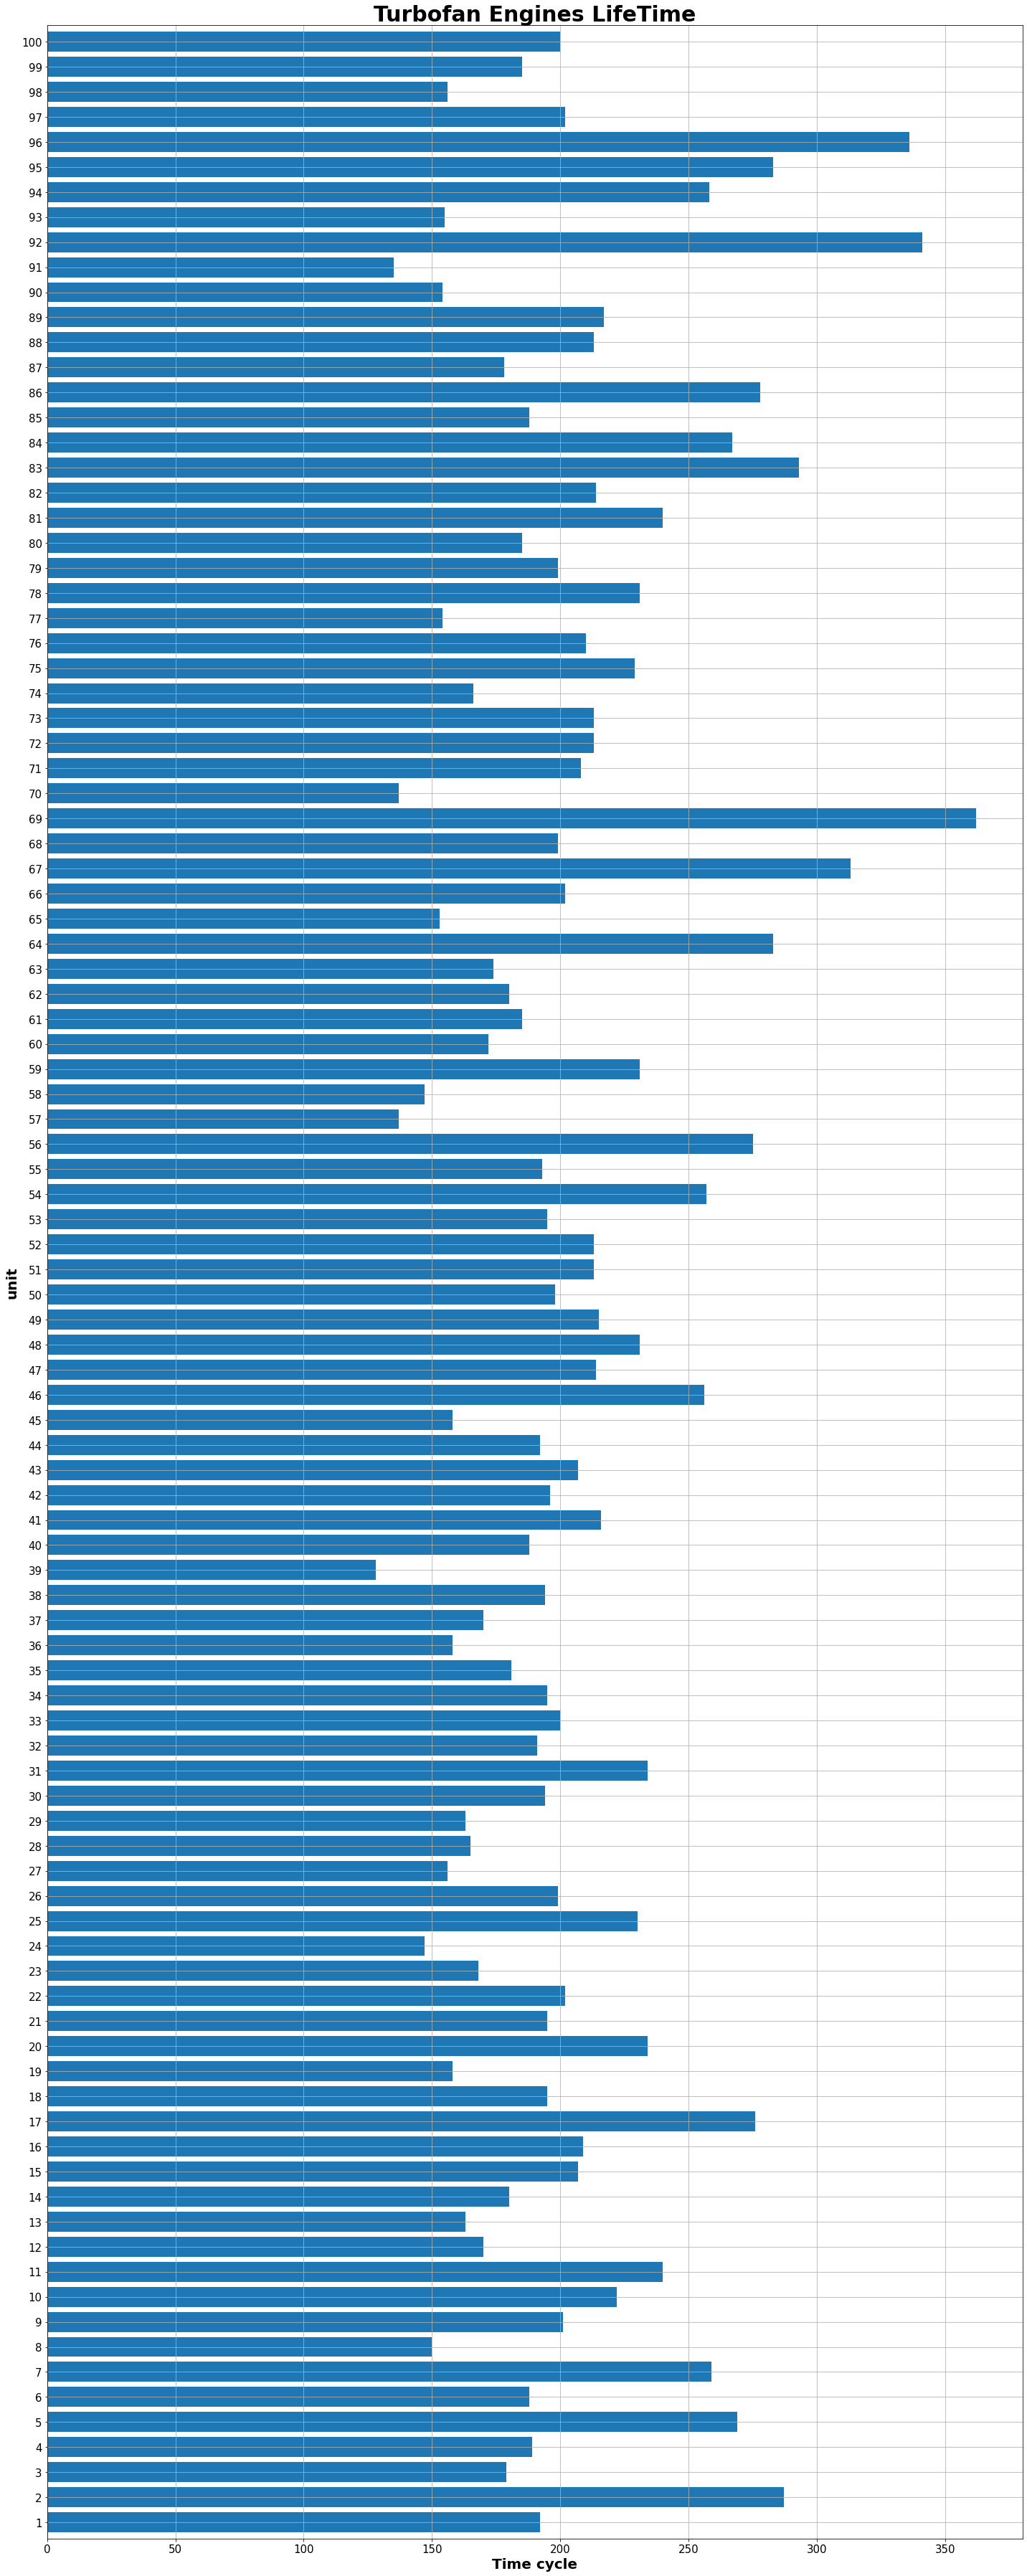

In [60]:
max_time_cycles=train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 6.800000000000011, 'max time cycle')

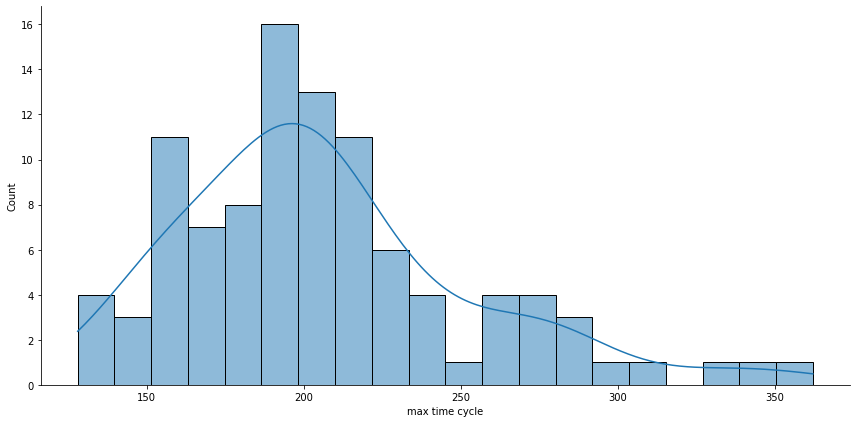

In [61]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

We notice that in most of the time, the maximum time cycles that an engine can achieve is between 190 and 210 before HPC failure.

### Add RUL column to the data

###### RUL  corresponds to the remaining time cycles for each unit before it fails.

In [62]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [63]:
train = add_RUL_column(train)

In [64]:
train[['unit_number','RUL']]

,unit_number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
...,...,...
20626,100,4
20627,100,3
20628,100,2
20629,100,1


In [65]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268


### Discovering Correlations 

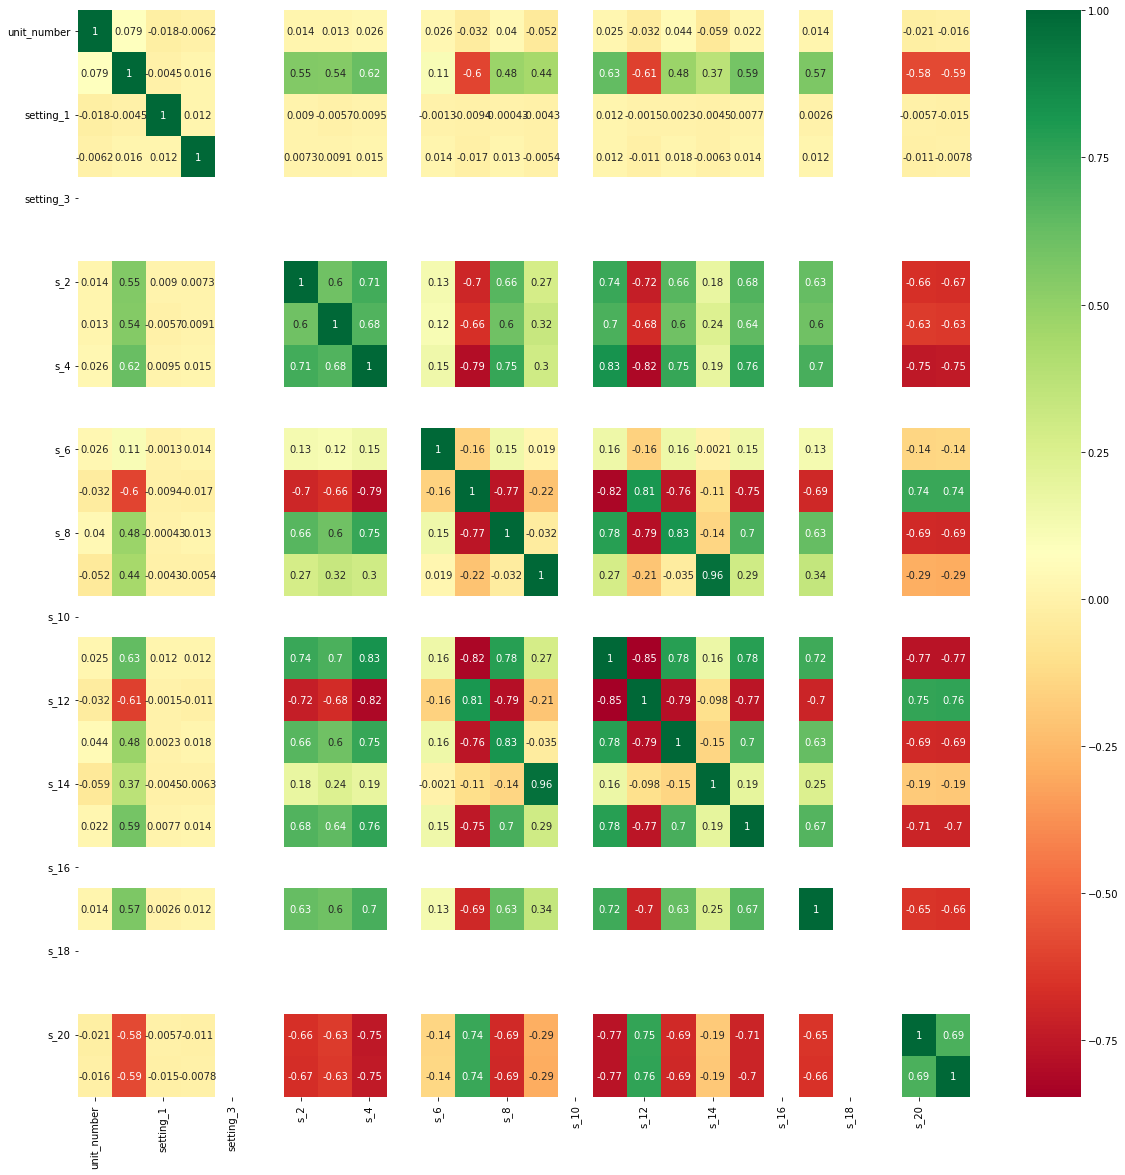

In [66]:
sns.heatmap(dftrain.corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

<AxesSubplot:>

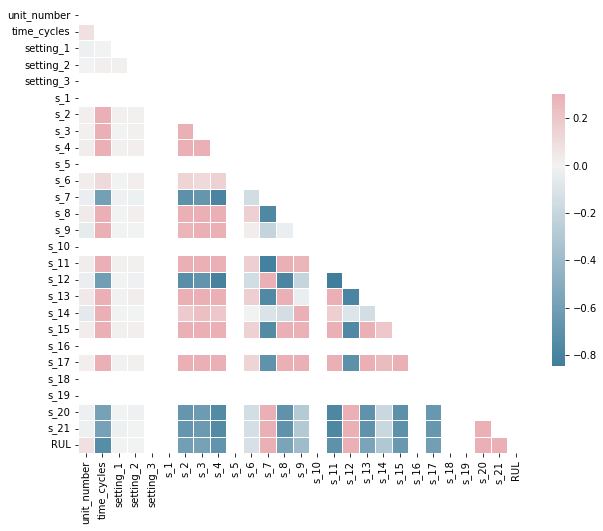

In [67]:
# Compute the correlation matrix
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

We notice that some features of our data-set are highly correlated with the target value RUL, other features present a low correlation which will be dropped later.

In [68]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

A **low pressure compressor (LPC**) and **high pressure compressor 
(HPC**) supply compressed high temperature, high pressure gases to the combustor.
**Low pressure turbine (LPT)** can decelerate and pressurize air to improve the chemical energy 
conversion efficiency of aviation kerosene.
**High pressure turbines (HPT)** generate mechanical energy by using high temperature and high pressure gas strike turbine blades. 
**Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle** guarantee the combustion 
efficiency of the engine.

#### Plotting the evolution of features (sensors) along with the evolution with RUL

In [69]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()


Function Definition:

def plot_signal(df, Sensor_dic, signal_name):: Defines a function named plot_signal that takes three parameters: a DataFrame (df), a dictionary mapping sensor names to their descriptions (Sensor_dic), and the name of the signal to be plotted (signal_name).

Plotting Sensor Signals:

* for i in df['unit_number'].unique():: Iterates over unique unit numbers in the DataFrame.
* if (i % 10 == 0):: Checks if the unit number is a multiple of 10 (e.g., 10, 20, 30, ...). This is done to visualize signals for a subset of units for better clarity.
* plt.plot('RUL', signal_name, data=df[df['unit_number'] == i].rolling(10).mean()): Plots the rolling mean of the specified sensor signal over RUL for the selected units.

Plot Customization:

* plt.xlim(250, 0): Sets the x-axis limits to reverse the order of RUL (counts down to zero).
* plt.xticks(np.arange(0, 300, 25)): Sets custom x-axis ticks.
* plt.ylabel(Sensor_dic[signal_name]): Sets the y-axis label using the sensor description from the dictionary.
* plt.xlabel('Remaining Useful Life'): Sets the x-axis label.

Display the Plot:

plt.show(): Displays the generated plot.

This function is designed to visualize sensor signals over the Remaining Useful Life for a subset of units. The rolling mean is applied to smoothen the curves. You can customize the function by adjusting parameters and labels based on your specific dataset and visualization preferences.

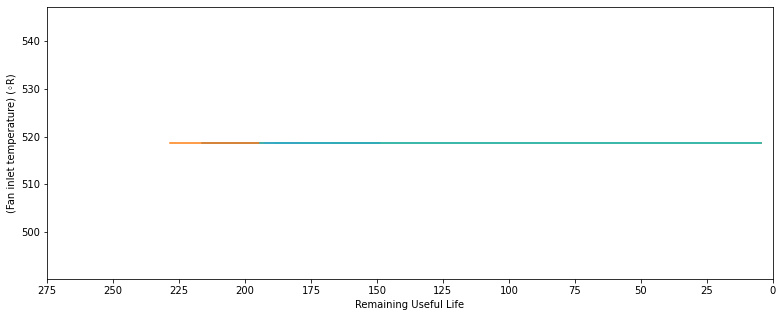

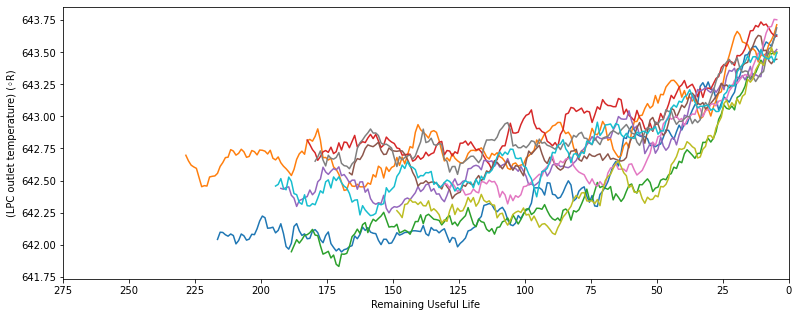

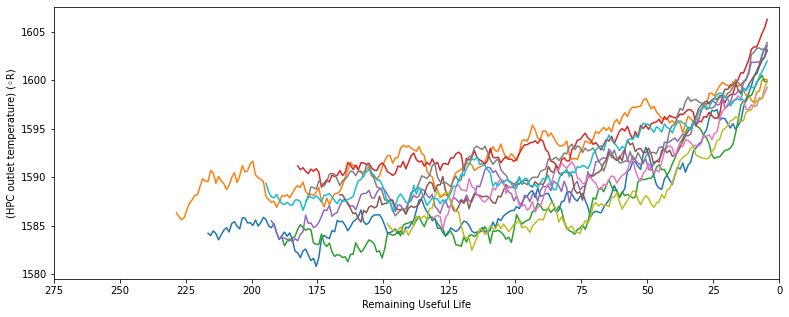

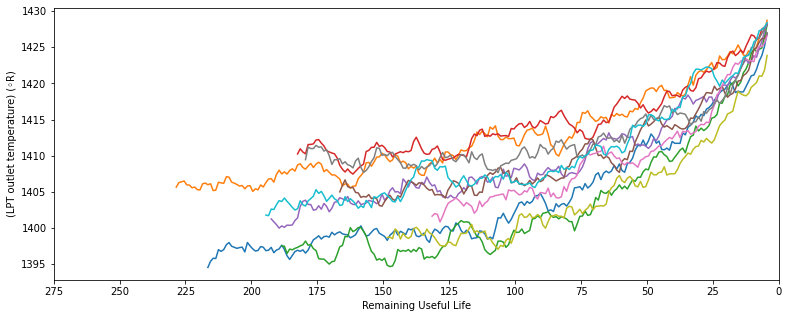

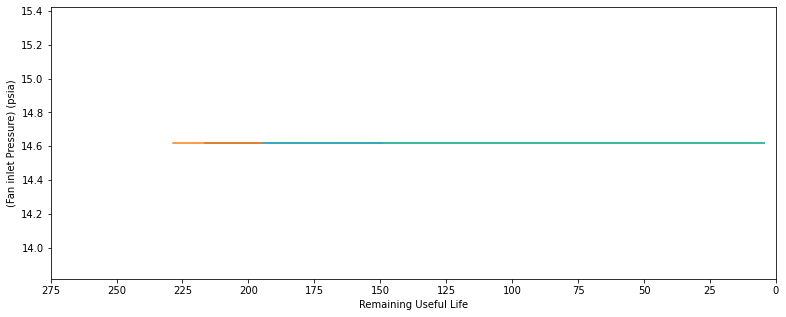

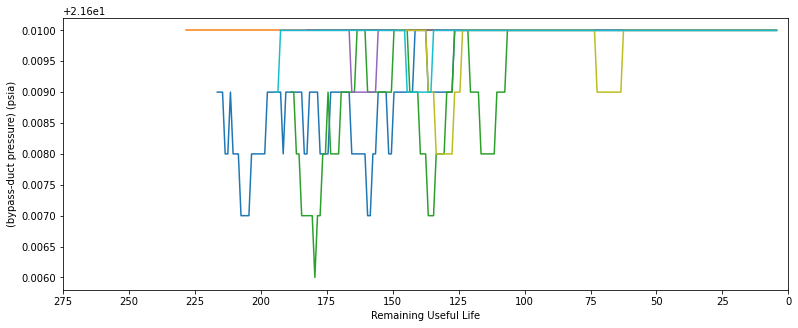

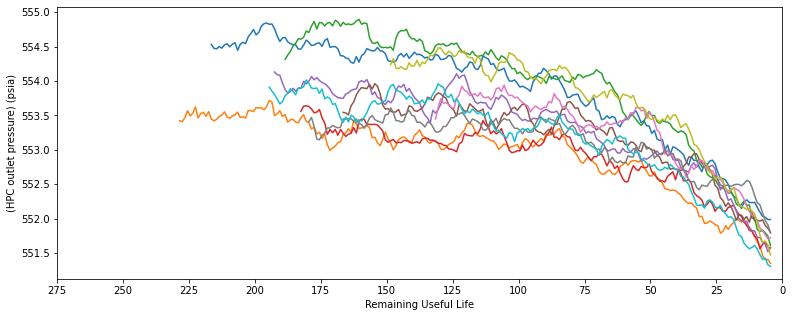

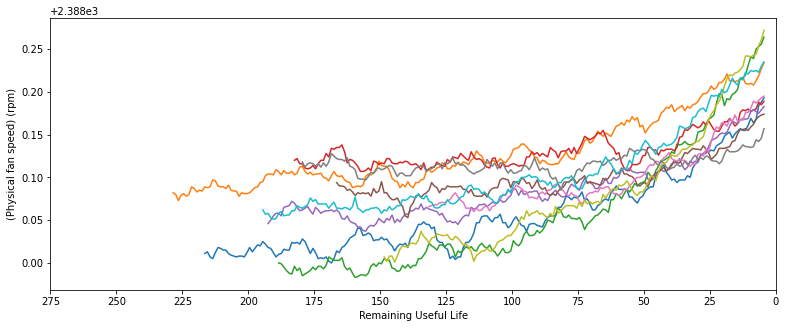

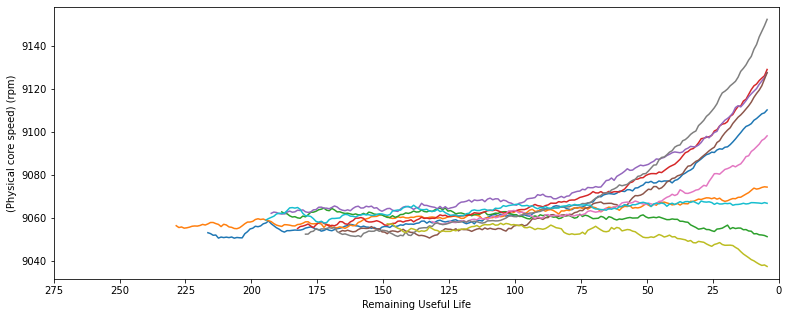

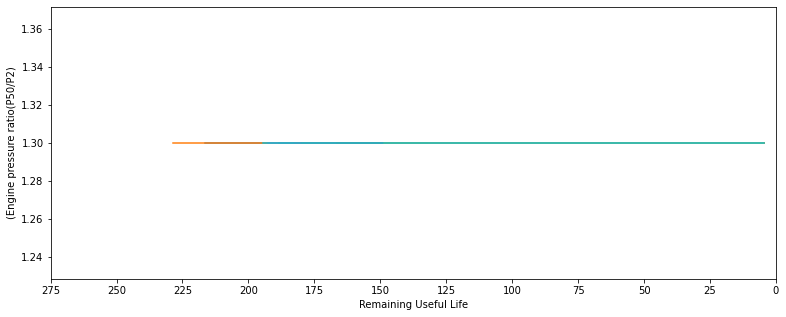

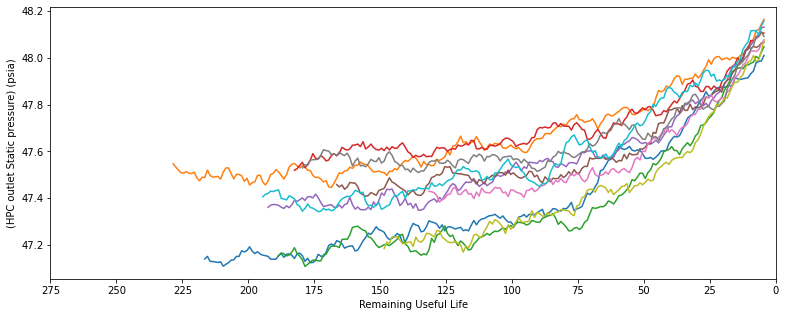

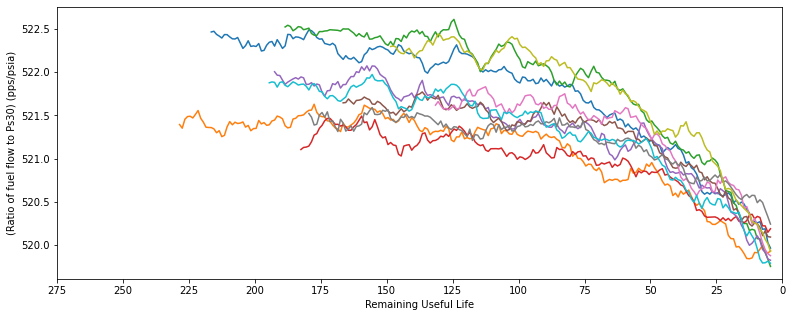

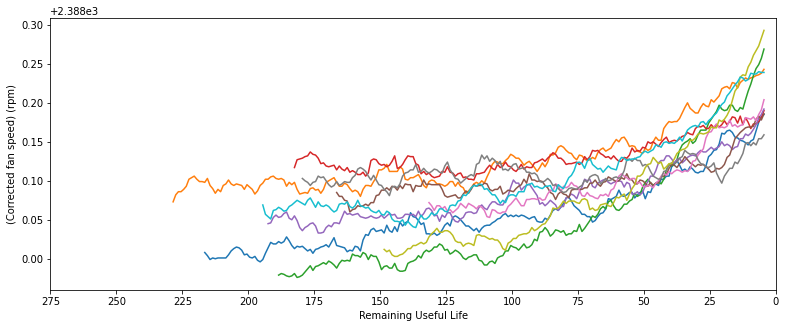

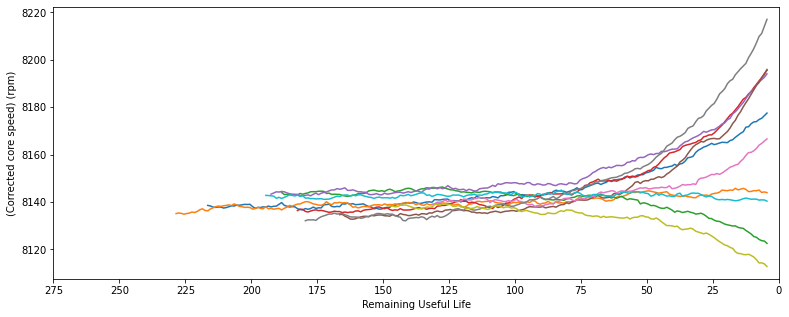

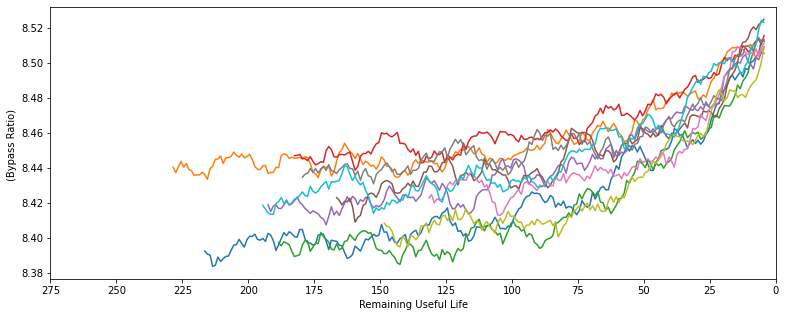

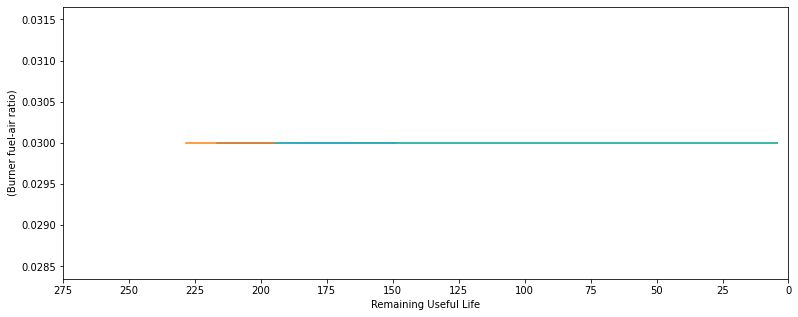

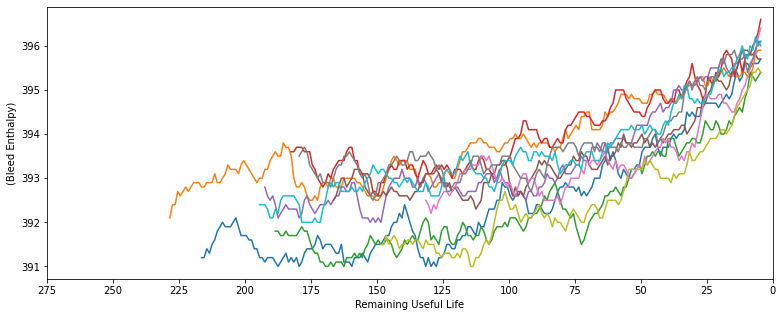

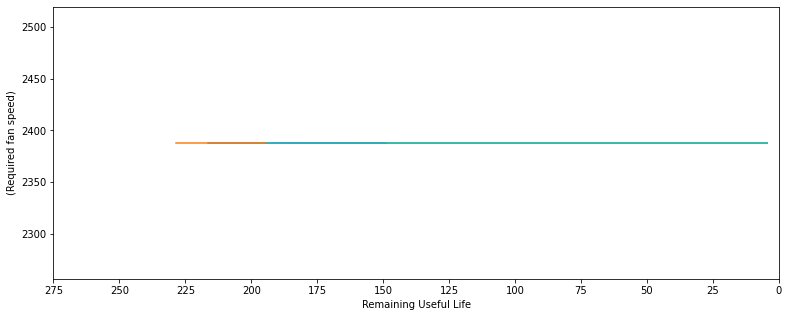

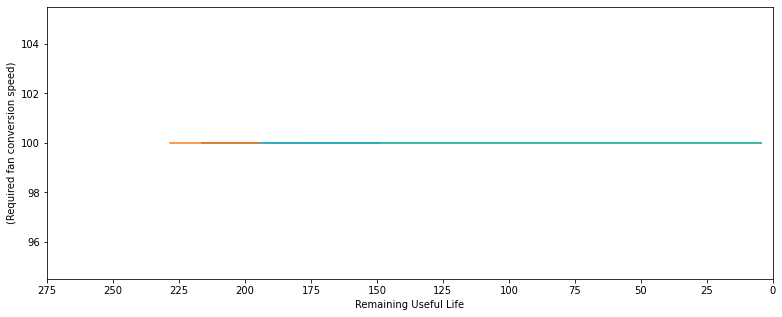

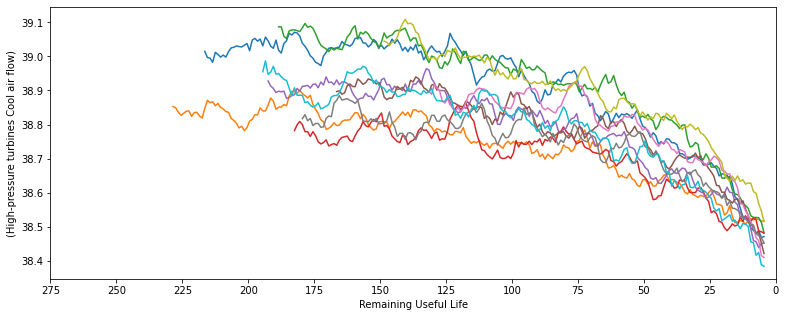

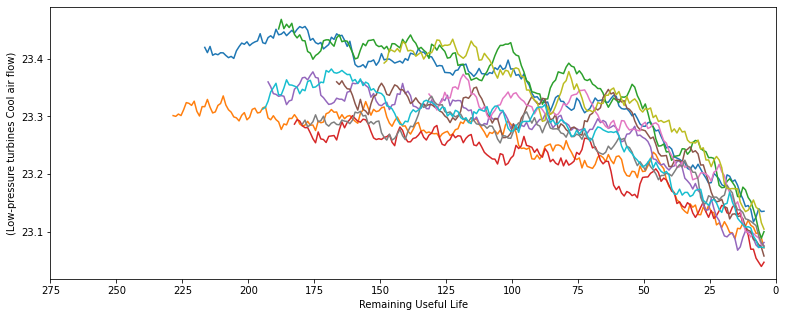

In [70]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

These plots show that some sensors are constant. Hence they don't influence the RUL ==> we can drop those ones. (later)

For Loop:

for i in range(1, 22):: Iterates over the range of numbers from 1 to 21.

Plotting Attempt:

try:: Attempts to execute the code block within the try block.
plot_signal(train, Sensor_dictionary, 's_' + str(i)): Calls the plot_signal function for the i-th sensor signal ('s_1', 's_2', ..., 's_21').

Exception Handling:

except:: Catches any exceptions that may occur during the execution of the try block.
pass: If an exception occurs, it does nothing and continues to the next iteration of the loop.
This loop is useful for automatically generating plots for multiple sensor signals without the script terminating if there's an issue with one of the plots. It provides a convenient way to visualize a series of sensor signals without manually calling the plot_signal function for each signal.

Adjustments can be made to the loop range or other parameters based on your specific requirements and dataset.

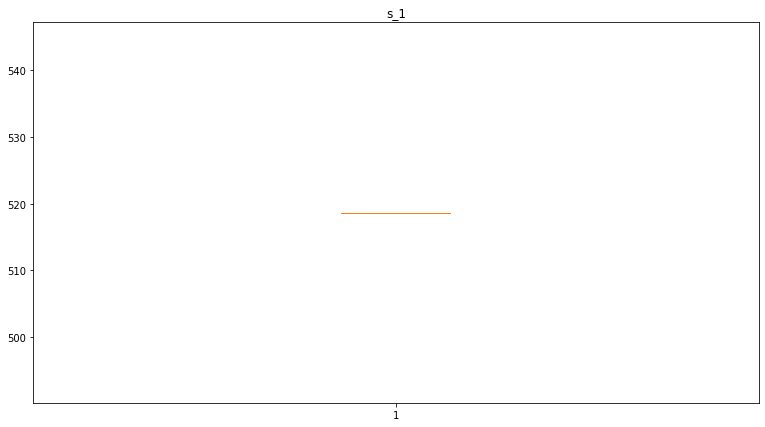

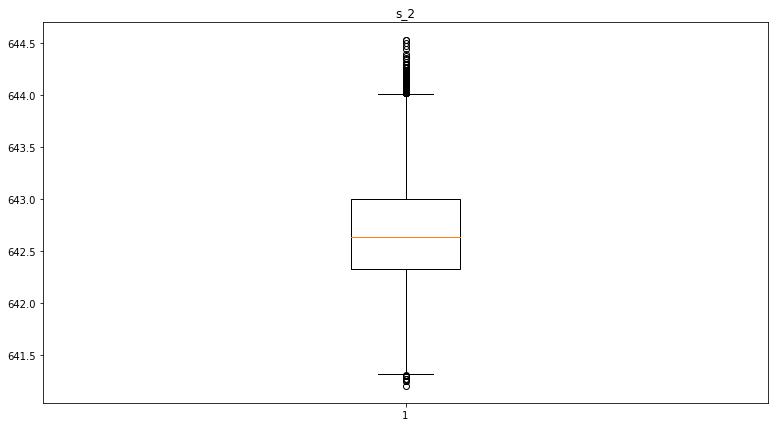

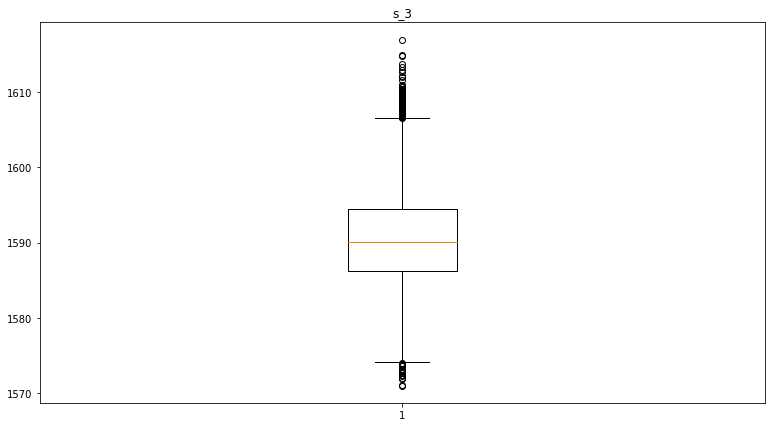

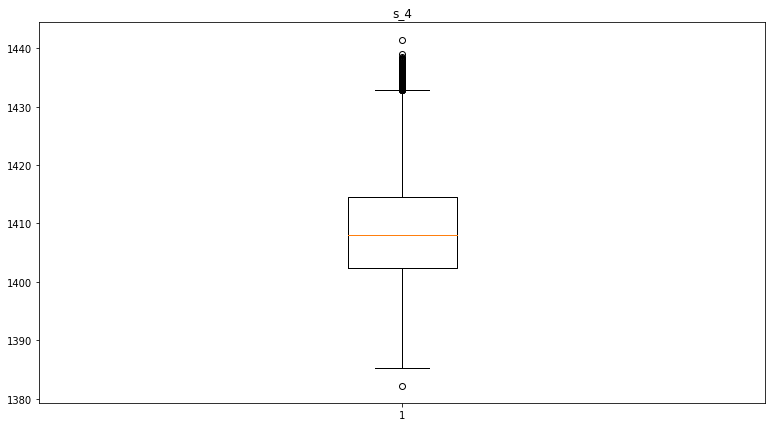

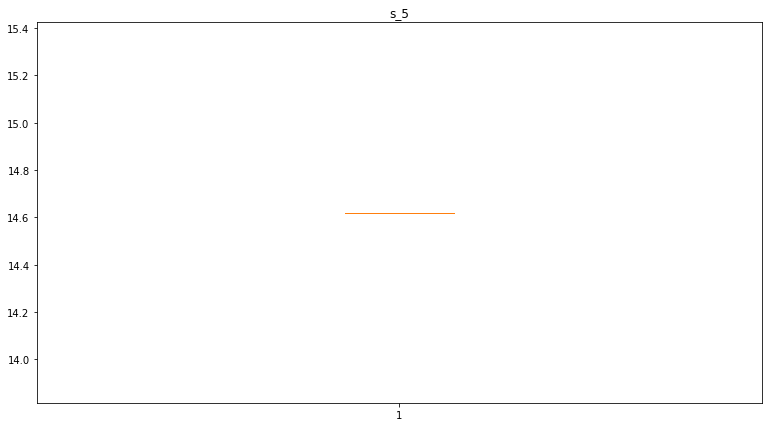

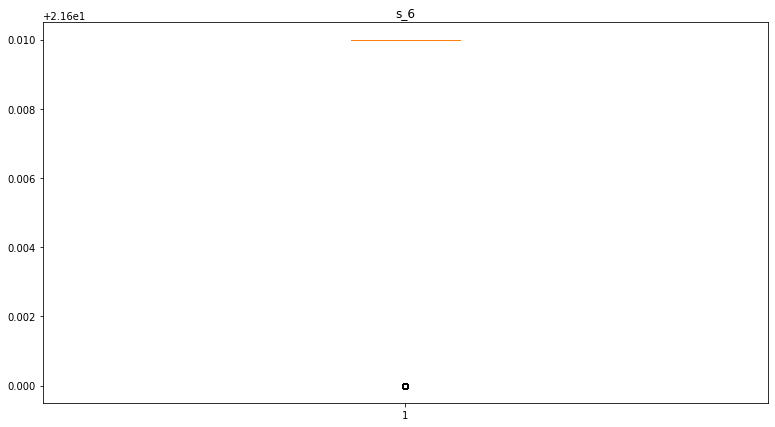

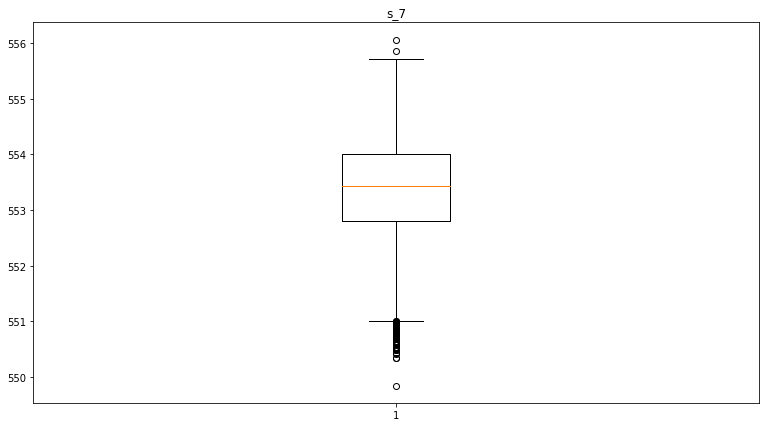

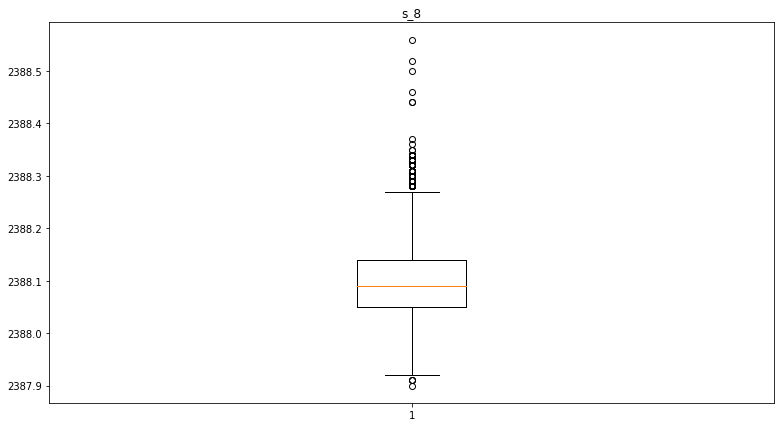

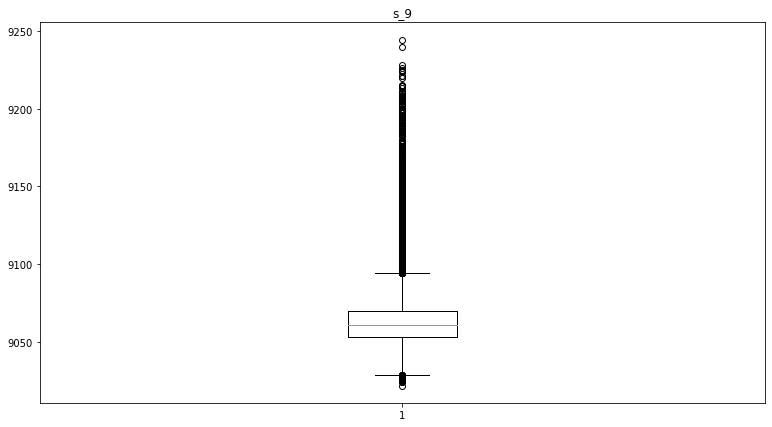

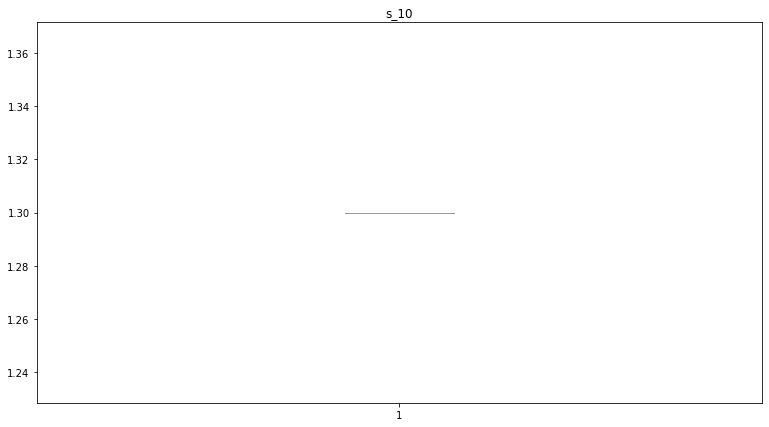

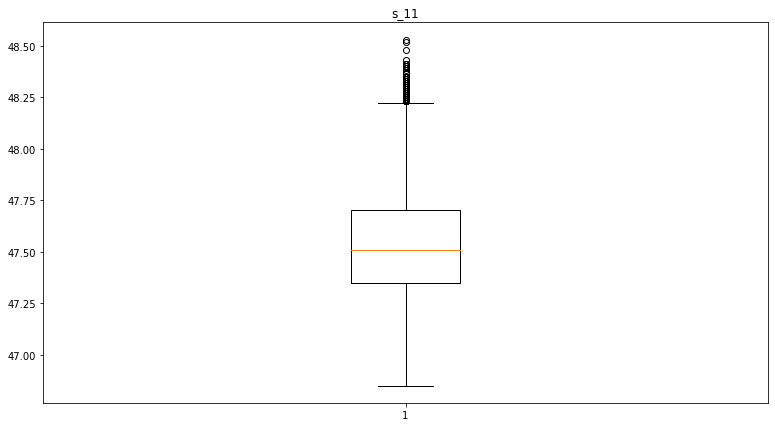

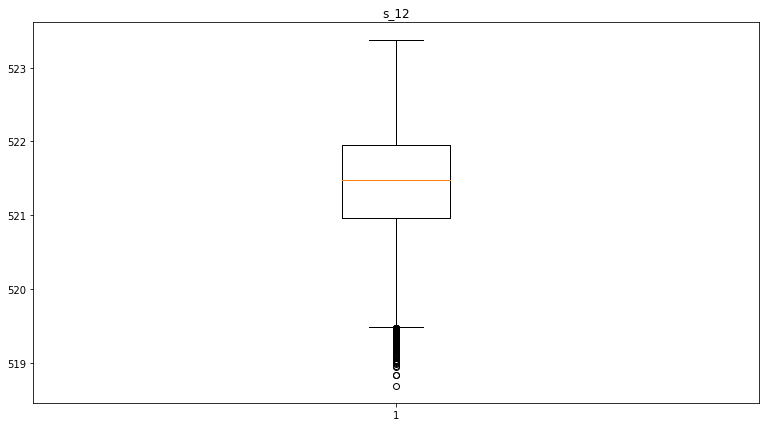

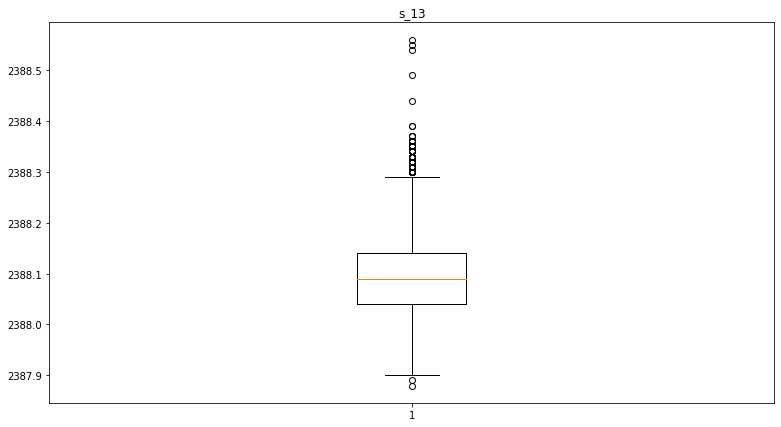

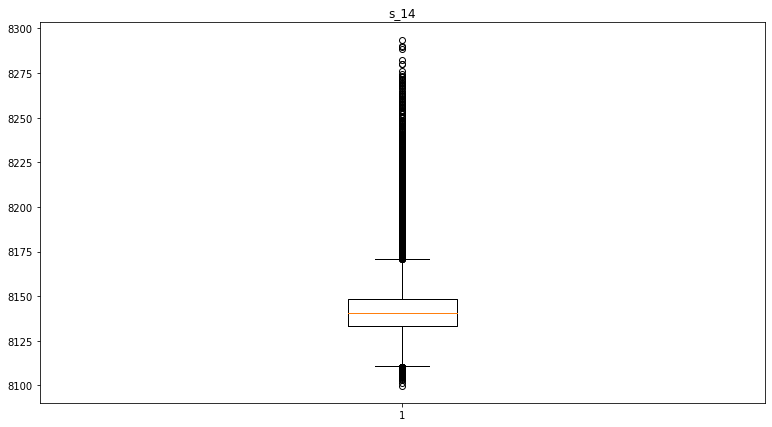

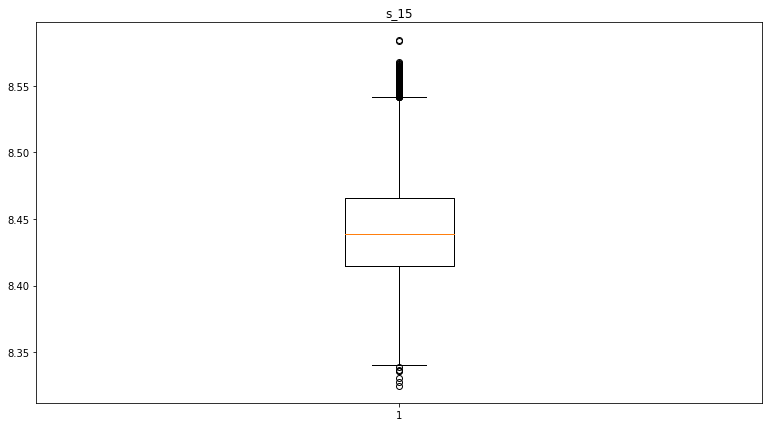

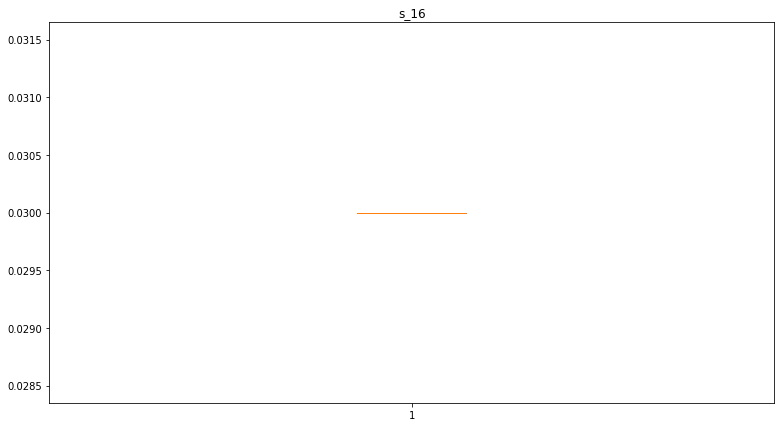

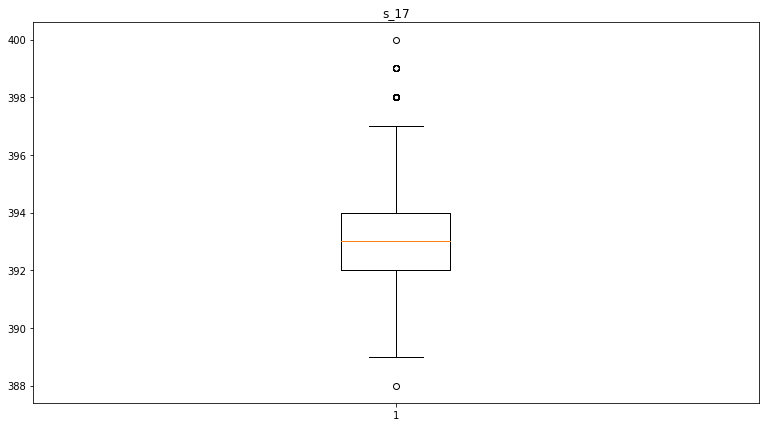

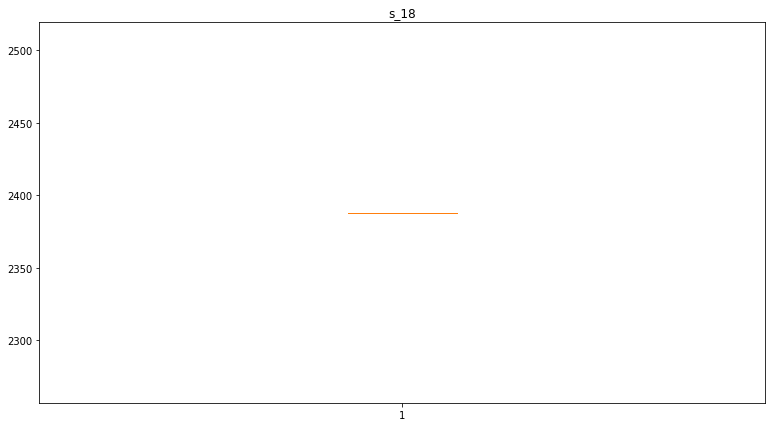

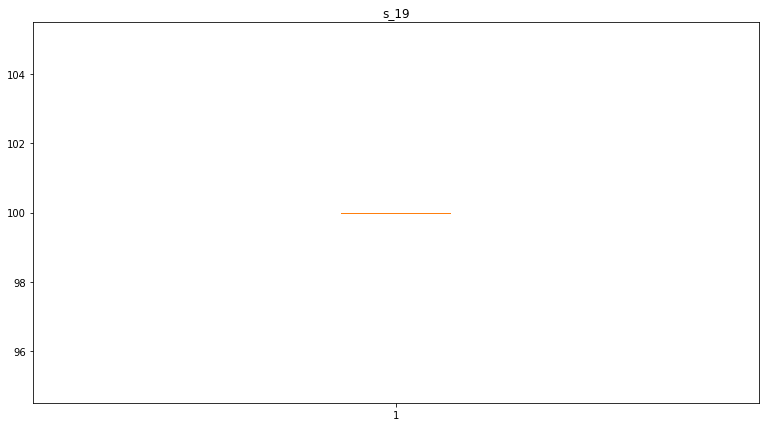

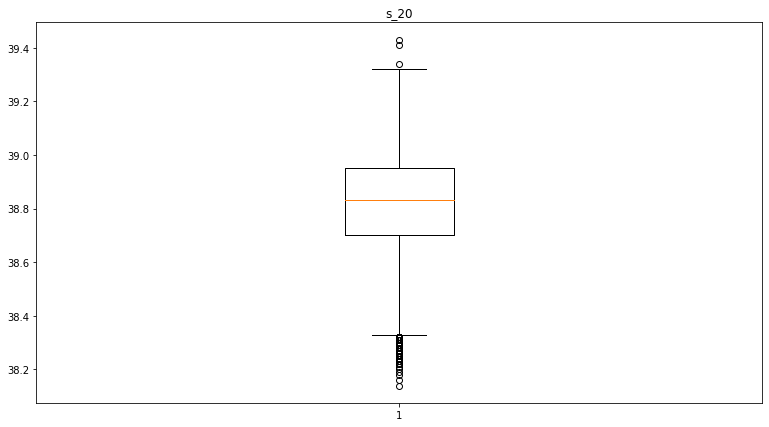

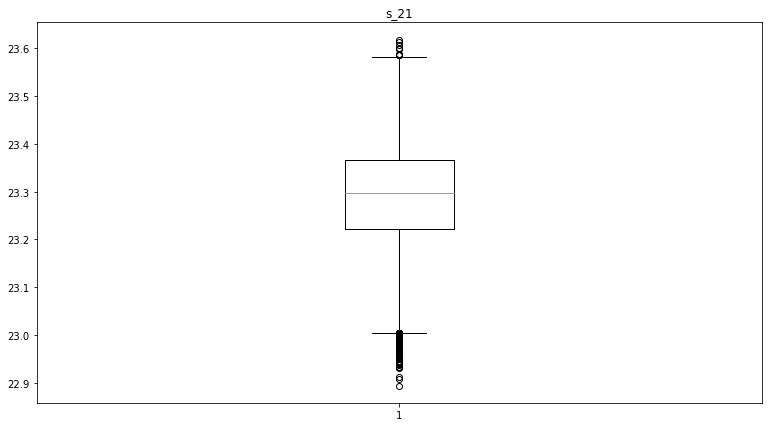

In [71]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

Observing the signal plots and the boxplots, we notice that the sensors 1,5,10,16,18,19 are constant, furthermore, we observe that the other sensors aren't well distributed and there are many outliers, then we should scale our data 

In [72]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


 The last point is more supported by the fact that the statistic properties of sensors data show that they don't have the same scale and they don't follow a normal distribution ==> this can be solved by performing a Minmax scaler on our data.

**MinMax scaler function** :Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set
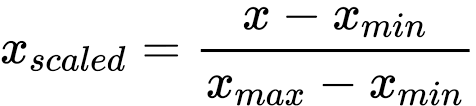!

##### Dropping unnecessary features (labels and settings)

In [73]:
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)

##### Scaling the data

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Droping the target variable
X_train.drop(columns=['RUL'], inplace=True)
X_test.drop(columns=['RUL'], inplace=True)
#Scaling X_train and X_test
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
#Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)


Grouping by 'unit_number' and Taking the Last Observation:

* X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
* valid.groupby('unit_number').last(): Groups the 'valid' DataFrame by 'unit_number' and selects the last observation within each group.
* reset_index(): Resets the index of the resulting DataFrame.
* drop(columns=drop_labels): Drops specified columns from the DataFrame.

Scaling X_valid:

* X_valid_s = scaler.fit_transform(X_valid)
* scaler.fit_transform(X_valid): Uses the fit_transform method of a scaler to scale the features in X_valid. This involves computing the mean and standard deviation from the training data (X_train) and then applying the transformation to the validation data.
It's important to note that the fit_transform method should be used with the same scaler that was fitted on the training data (X_train). This ensures that the same scaling parameters are applied to both the training and validation datasets, maintaining consistency.

In [75]:
X_valid

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,518.67,642.30,1590.88,1397.94,14.62,21.61,553.99,2388.03,9062.41,1.3,...,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
96,518.67,642.59,1582.96,1410.92,14.62,21.61,554.05,2388.06,9076.36,1.3,...,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
97,518.67,642.68,1599.51,1415.47,14.62,21.61,553.44,2388.13,9062.34,1.3,...,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608
98,518.67,642.00,1585.03,1397.98,14.62,21.61,554.75,2388.01,9067.16,1.3,...,521.82,2388.02,8150.38,8.4003,0.03,391,2388,100.0,38.95,23.3595


In [76]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


#### plotting features new distribution

array([[<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_4'}>,
        <AxesSubplot:title={'center':'s_7'}>],
       [<AxesSubplot:title={'center':'s_8'}>,
        <AxesSubplot:title={'center':'s_9'}>,
        <AxesSubplot:title={'center':'s_11'}>,
        <AxesSubplot:title={'center':'s_12'}>],
       [<AxesSubplot:title={'center':'s_13'}>,
        <AxesSubplot:title={'center':'s_14'}>,
        <AxesSubplot:title={'center':'s_15'}>,
        <AxesSubplot:title={'center':'s_17'}>],
       [<AxesSubplot:title={'center':'s_20'}>,
        <AxesSubplot:title={'center':'s_21'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

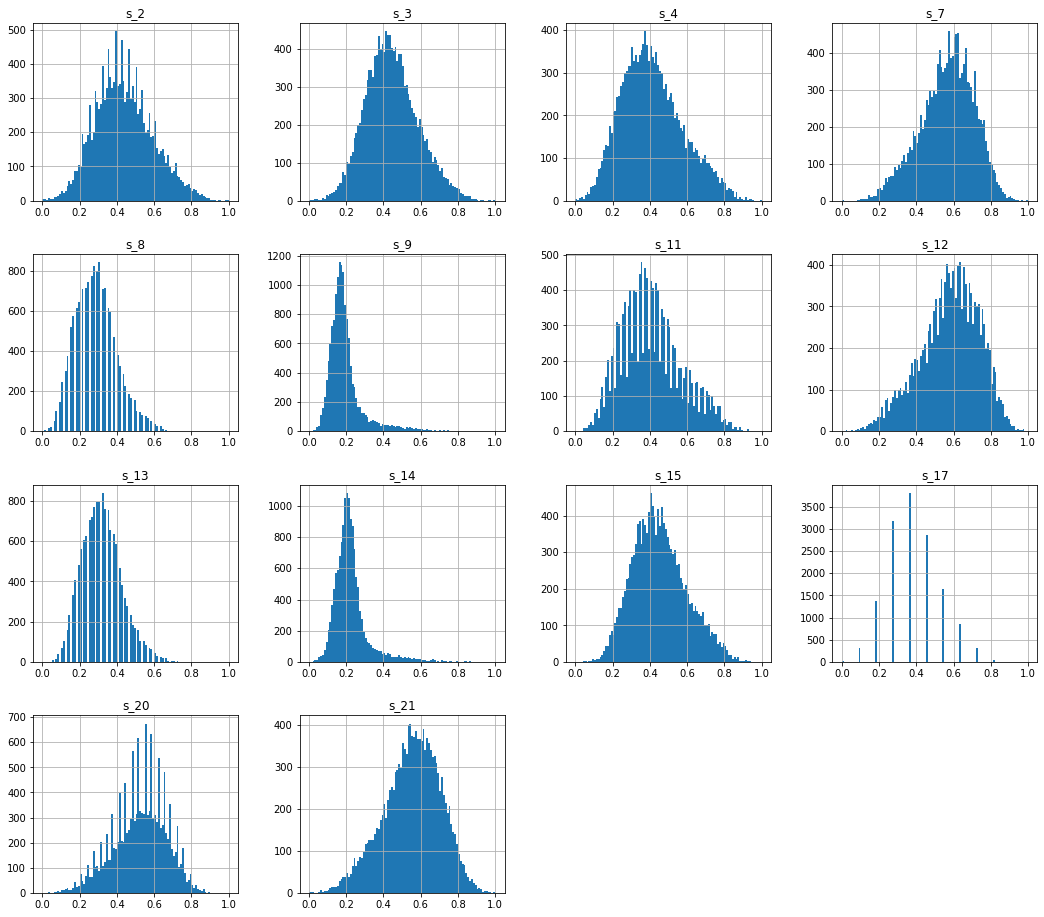

In [77]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Models Implementation and instantiation

#### Linear regression

In [78]:
class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=150 ) :    
        self.lr = lr
        self.iterations = iterations     
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p )
        self.b = 0
        self.X = X
        self.Y = Y
        # gradientlearning      
        for i in range( self.iterations ) :  
            self.weight_updater()
        return self
         
    def weight_updater( self ) :
        Y_pred = self.predict( self.X )  
        #  gradients  
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self
          
    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b
     
  

#### SVR

In [79]:
from sklearn.svm import SVR
import tensorflow as tf
regressor = SVR(kernel='rbf')

#### Random forest

In [80]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)


### Defining evaluation functions

In [81]:
#R2 score & RMSE & MAER
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [82]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### Using Every Feature


#### Linear regresssion

In [83]:
lr=Linear_Regression() #Instantiation
lr.fit(X=X_train_s, Y=y_train) #Fitting 

y_lr_train = lr.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s)  #Prediction on test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid= lr.predict(X_valid_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:56.19869318681088, R2:0.3439361345919162
test set RMSE:54.264009074691856, R2:0.35713062175493715
valid set RMSE:34.84962228223509, R2:0.2967064952591343


### SVR

In [84]:
regressor.fit(X_train_s, y_train) # fitting

y_svr_train = regressor.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) #Prediction on test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid= lr.predict(X_valid_s)  #Prediction on validation data
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:43.56448464126648, R2:0.605761670162996
test set RMSE:47.26718449996112, R2:0.5122262167433573
valid set RMSE:34.84962228223509, R2:0.2967064952591343


#### Random forest regressor

In [85]:
# gridsearch goes here
rf.fit(X_train_s, y_train)
# predict and evaluate
y_rf_train = rf.predict(X_train_s)
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:15.408303170220156, R2:0.9506822432050425
test set RMSE:44.36383009860364, R2:0.5703082128383993
valid set RMSE:30.653618024631285, R2:0.45586841183607596


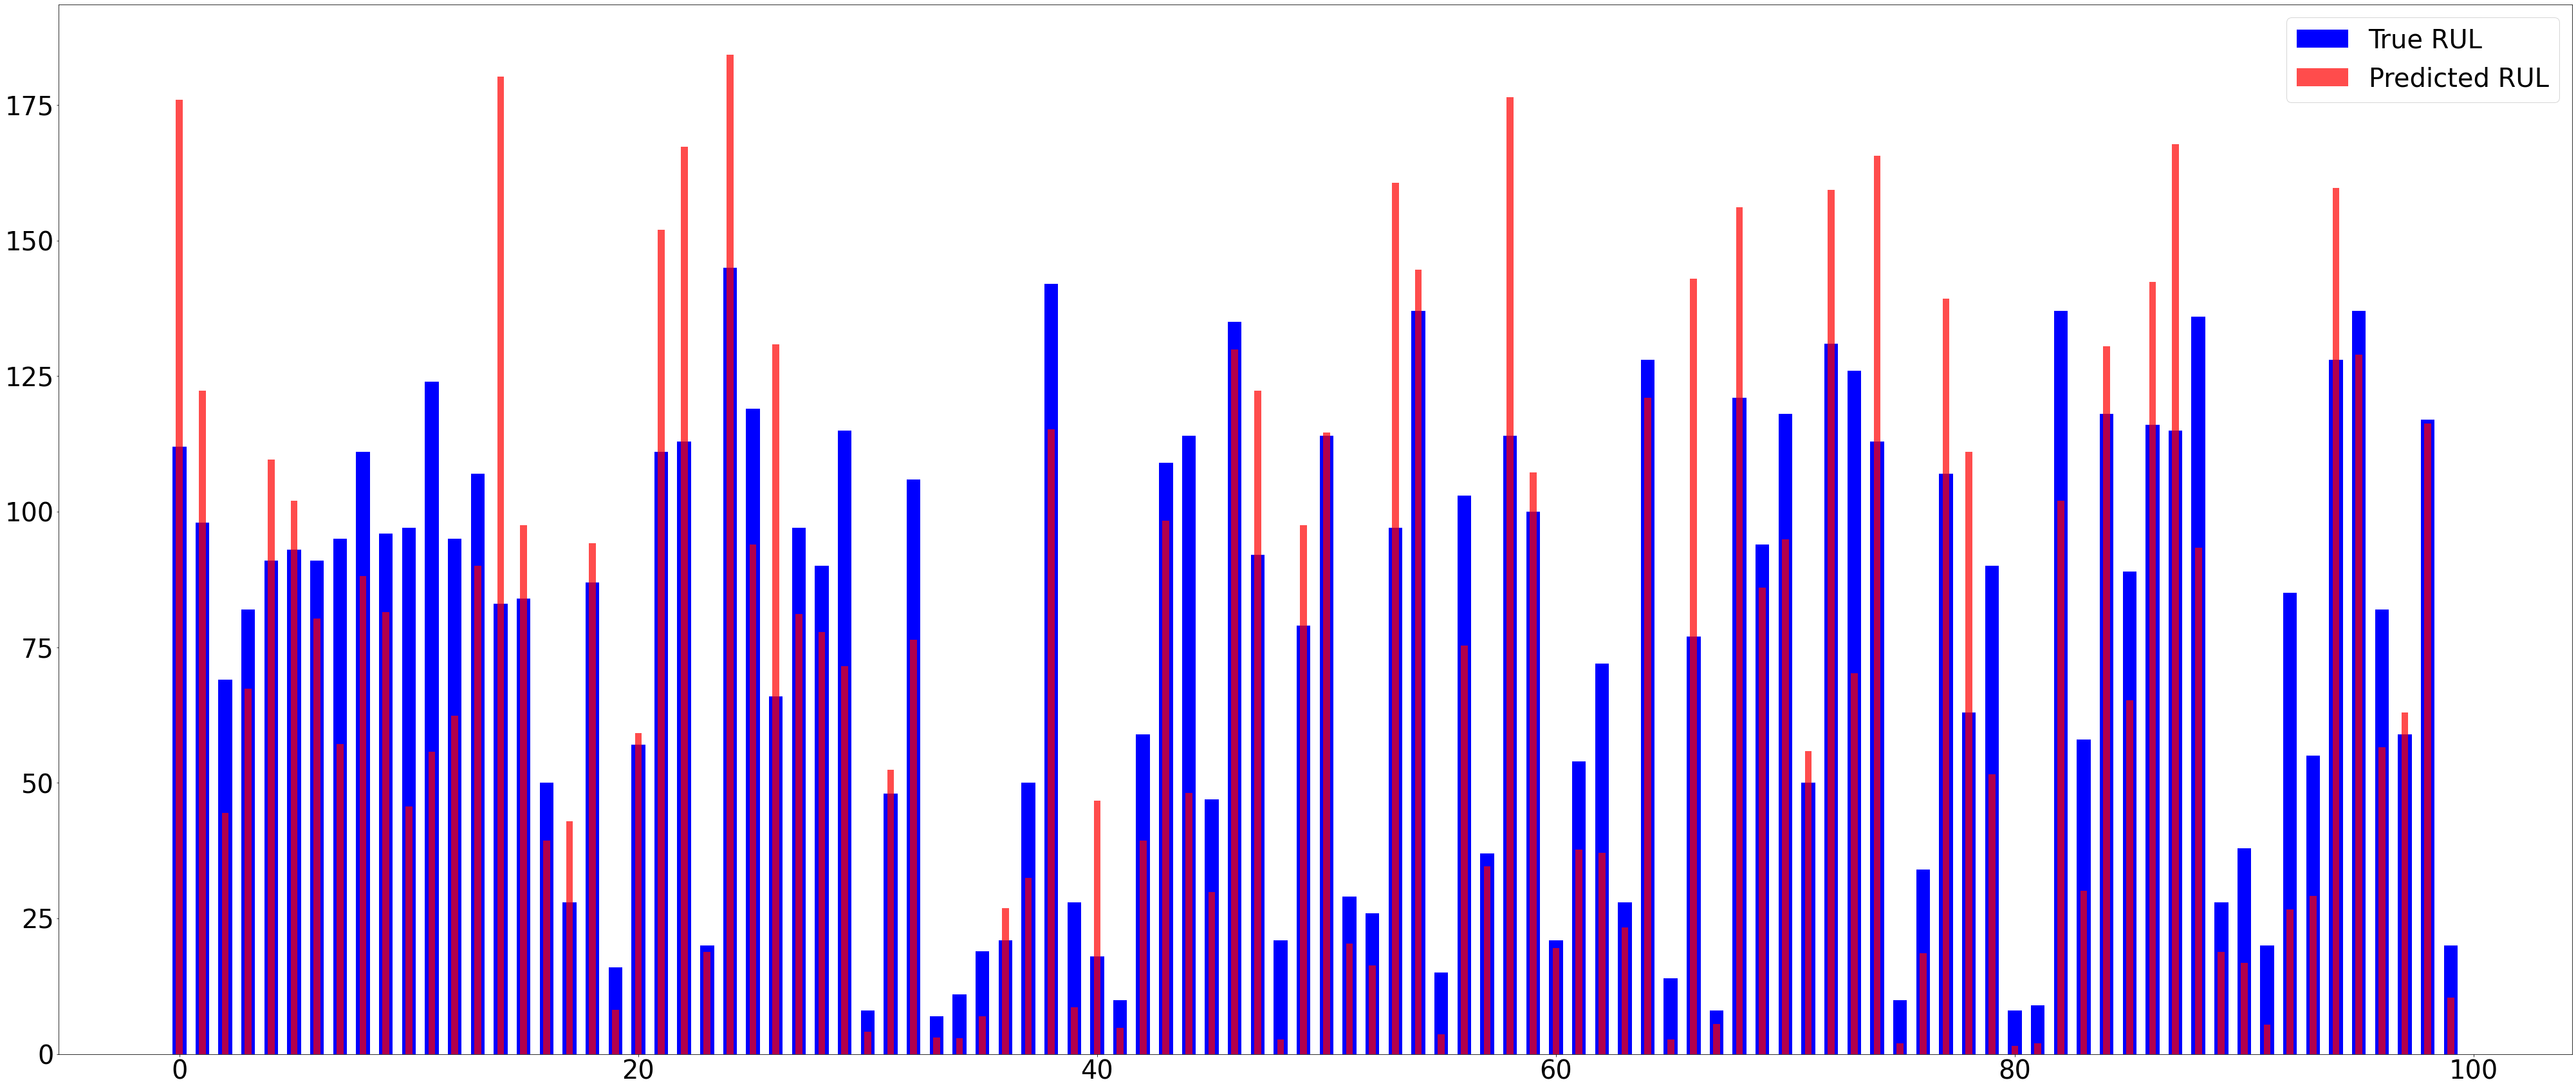

In [86]:
plot_predActual(y_valid, y_rf_valid)

The model overestimates the RUL. Future check for feature importance needed.

### 2nd attempt (Data without useless sensors, without historical data)

In  this section we drop constant signals, and we noticed in the max_time_cycles plot that in most of the time the maximum value is in the interval [190,210], hence we will set the maximum RUL to 195 through RUL clipping,

Considering that every RUL higher than 195 is equivalent to 195 will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL.

In [87]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_test :  360
maximum of y_valid :  RUL    145
dtype: int64


(array([1023., 1066., 1083., 1120.,  937.,  557.,  237.,  117.,   35.,
          15.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

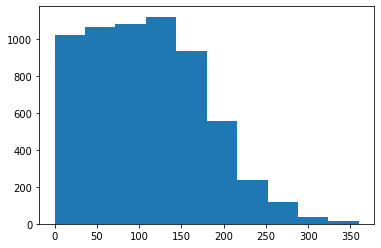

In [88]:
plt.hist(y_test)

In [89]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2=X_train.drop(columns=drop_labels2, axis=1) # drop the constant columns from the train dataset
X_test_2=X_test.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the test dataset
X_train_2_s=scaler.fit_transform(X_train_2) #scaling X_train_2
X_test_2_s=scaler.fit_transform(X_test_2) #scaling X_test_2
y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value
X_valid_2=X_valid.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the validation dataset
X_valid_2_s=scaler.fit_transform(X_valid_2) #scaling X_valid_2

## Linear Regression

In [90]:
lr=Linear_Regression()
lr.fit(X=X_train_2_s, Y=y_train_clip)

y_lr_train = lr.predict(X_train_2_s)
evaluate(y_train_clip,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_2_s)
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_2_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:47.86312955545103, R2:0.3792662465007206
test set RMSE:55.6261002397046, R2:0.3244519972933424
valid set RMSE:34.21070108960351, R2:0.3222579927041398


## SVR

In [91]:
regressor.fit(X_train_2_s, y_train)

y_svr_train = regressor.predict(X_train_2_s)
evaluate(y_train_clip,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_2_s)
evaluate(y_test, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_2_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:32.91543148706822, R2:0.7064363470171213
test set RMSE:48.75516379159361, R2:0.48103242301470384
valid set RMSE:25.947912225366206, R2:0.6101071274546097


## Random Forest 

In [92]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:12.036862499525814, R2:0.9607418547981479
test set RMSE:45.81838291793876, R2:0.5416697719315231
valid set RMSE:26.548403567823055, R2:0.5918523714819


### Using XGBoost 

In [93]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)


y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip,y_xgb_train, label='train')

y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test, y_xgb_test, label='test')

y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')

train set RMSE:35.70696026075914, R2:0.654531114904072
test set RMSE:49.912498111969036, R2:0.4561018273422788
valid set RMSE:25.724617971451206, R2:0.6167886852735663


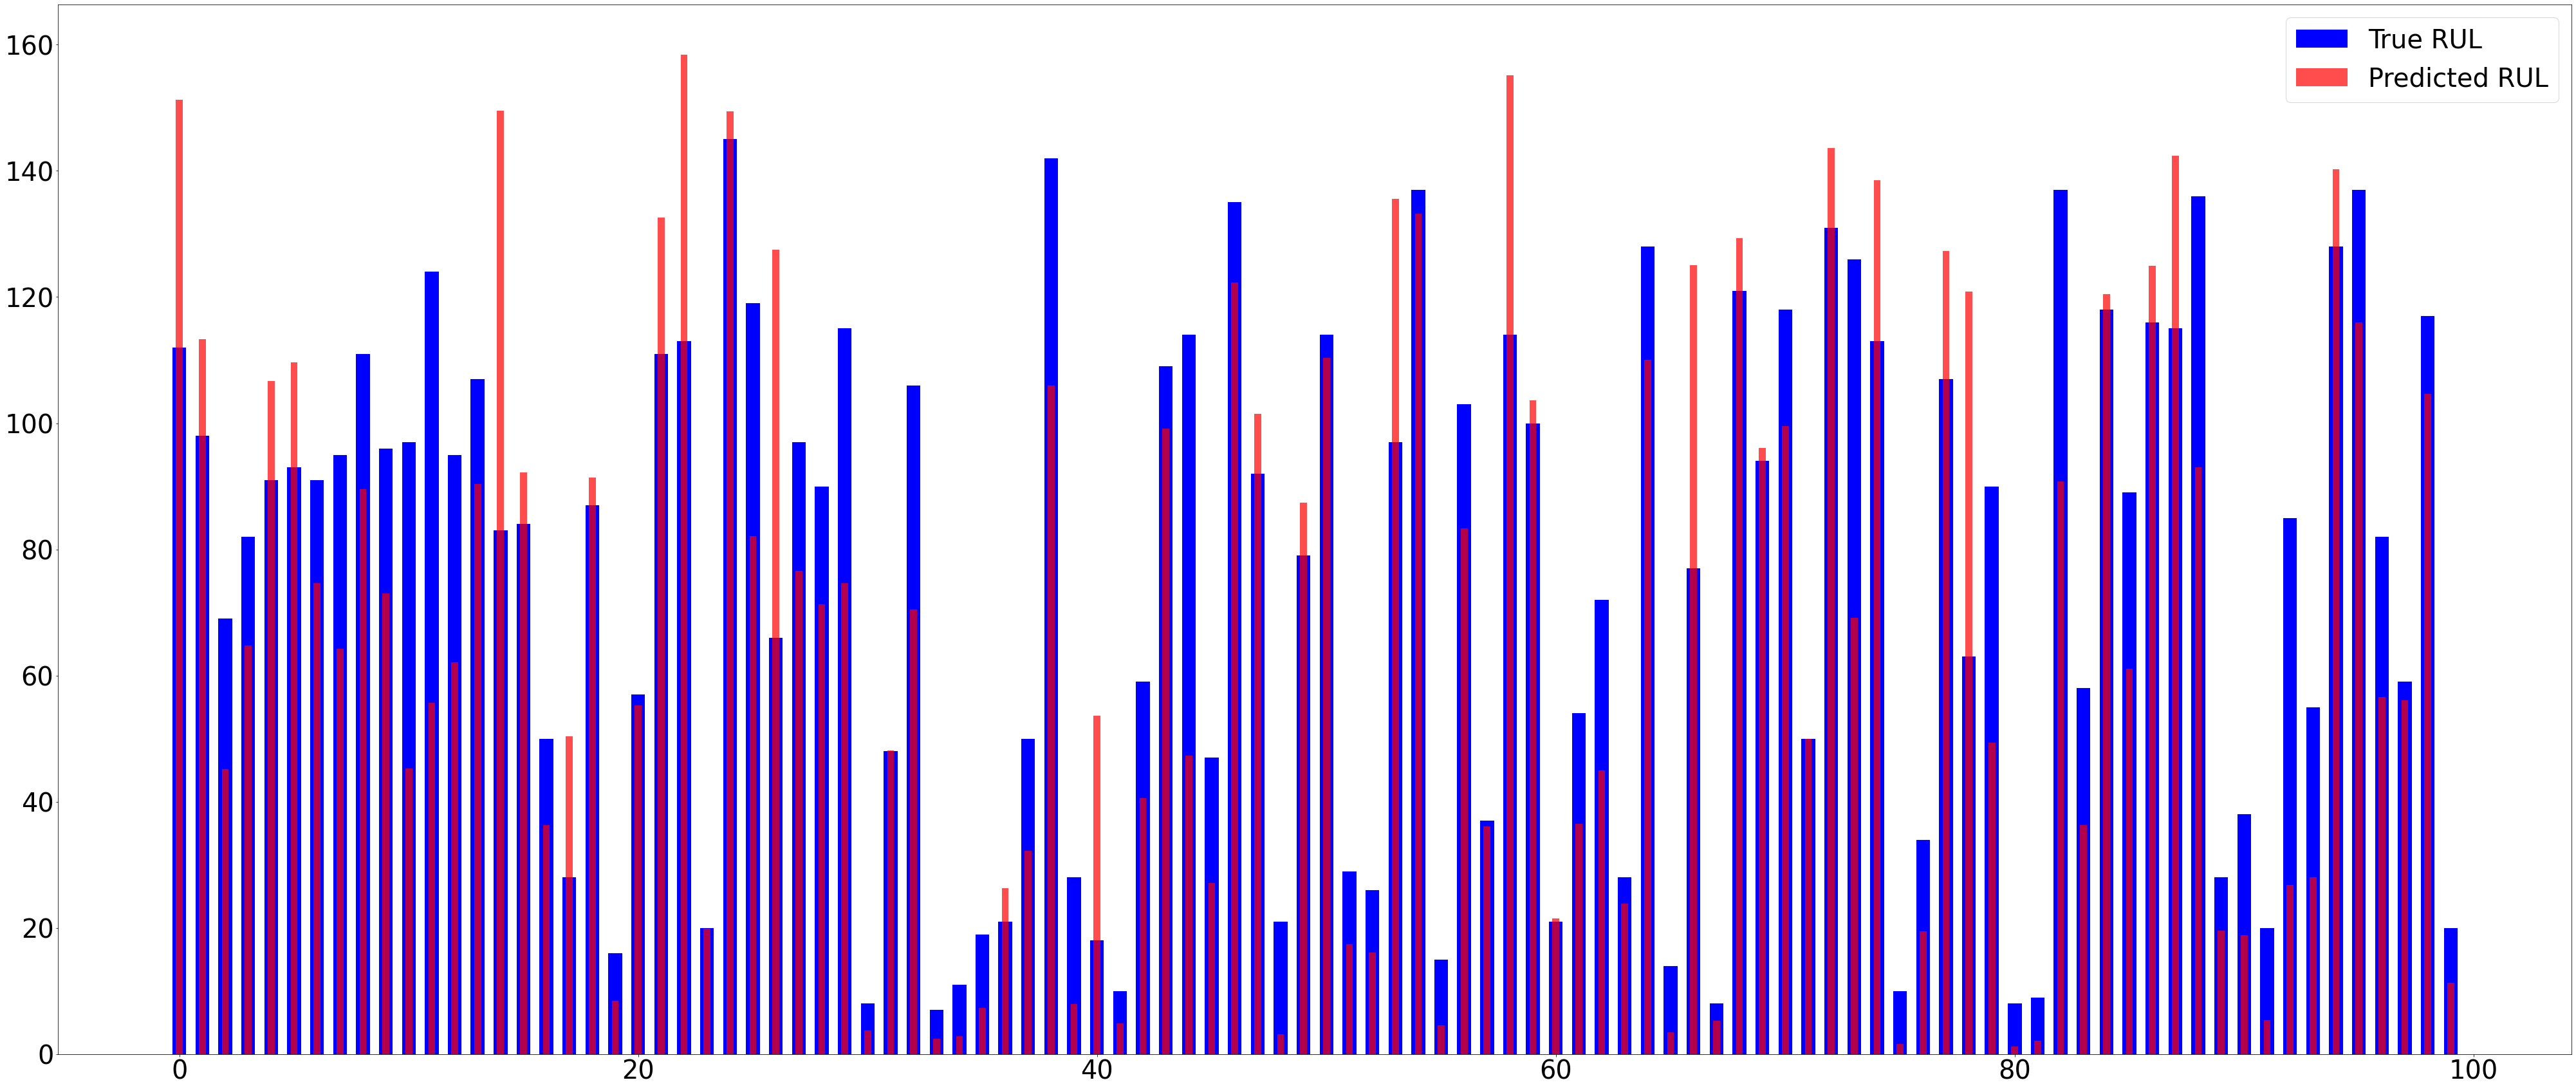

In [94]:
plot_predActual(y_valid, y_rf_valid)

Note: Future optimization using Grid Search and historical data is needed 